In [1]:
# 15m 收在下布林，且下影線大於實體Ｋ及上影線
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1662002785000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600 # 15min

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)

    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

                Close_Time     Open    Close     High      Low      Volume
0      2022-09-01 11:44:59  1555.61  1545.49  1557.26  1545.48   6613.3016
1      2022-09-01 11:59:59  1545.48  1549.91  1555.07  1537.23  13087.6580
2      2022-09-01 12:14:59  1549.92  1545.44  1555.00  1543.40   5091.3410
3      2022-09-01 12:29:59  1545.44  1550.86  1553.00  1542.46   4105.1571
4      2022-09-01 12:44:59  1550.85  1554.31  1556.29  1550.83   4279.7125
...                    ...      ...      ...      ...      ...         ...
19669  2023-03-25 10:14:59  1753.88  1756.86  1756.87  1753.18   2965.6815
19670  2023-03-25 10:29:59  1756.87  1761.21  1762.43  1756.03   3057.5934
19671  2023-03-25 10:44:59  1761.21  1758.03  1761.93  1757.70   2898.1428
19672  2023-03-25 10:59:59  1758.03  1758.66  1759.41  1757.68   1737.6644
19673  2023-03-25 11:14:59  1758.65  1758.64  1759.00  1756.52   2655.8954

[19674 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi
0,2022-09-01 11:44:59,1555.61,1545.49,1557.26,1545.48,6613.3016,NaN,NaN,NaN,NaN,NaN
1,2022-09-01 11:59:59,1545.48,1549.91,1555.07,1537.23,13087.6580,NaN,NaN,NaN,NaN,NaN
2,2022-09-01 12:14:59,1549.92,1545.44,1555.00,1543.40,5091.3410,NaN,NaN,NaN,NaN,NaN
3,2022-09-01 12:29:59,1545.44,1550.86,1553.00,1542.46,4105.1571,NaN,NaN,NaN,NaN,NaN
4,2022-09-01 12:44:59,1550.85,1554.31,1556.29,1550.83,4279.7125,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
19669,2023-03-25 10:14:59,1753.88,1756.86,1756.87,1753.18,2965.6815,1751.333000,1765.489834,1751.333000,1737.176166,54.840830
19670,2023-03-25 10:29:59,1756.87,1761.21,1762.43,1756.03,3057.5934,1751.505667,1766.009544,1751.505667,1737.001789,59.364655
19671,2023-03-25 10:44:59,1761.21,1758.03,1761.93,1757.70,2898.1428,1751.513667,1766.031659,1751.513667,1736.995675,55.025118
19672,2023-03-25 10:59:59,1758.03,1758.66,1759.41,1757.68,1737.6644,1751.356333,1765.452708,1751.356333,1737.259959,55.715775


In [9]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c1_1 紅Ｋ
    # c1_2 綠Ｋ
    # c2 收盤 小於 布林下

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (df['Open'] > df['Close']) & (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (df['Close'] > df['Open']) & (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']

    # 條件達成
    df['signal'] = False
    df.loc[(df['c1_1'] | df['c1_2']) & df.c2, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,c1_1,c1_2,c2,signal,openbuy
0,2022-09-01 11:44:59,1555.61,1545.49,1557.26,1545.48,6613.3016,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2022-09-01 11:59:59,1545.48,1549.91,1555.07,1537.23,13087.6580,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False
2,2022-09-01 12:14:59,1549.92,1545.44,1555.00,1543.40,5091.3410,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
3,2022-09-01 12:29:59,1545.44,1550.86,1553.00,1542.46,4105.1571,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
4,2022-09-01 12:44:59,1550.85,1554.31,1556.29,1550.83,4279.7125,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19669,2023-03-25 10:14:59,1753.88,1756.86,1756.87,1753.18,2965.6815,1751.333000,1765.489834,1751.333000,1737.176166,54.840830,False,False,False,False,False
19670,2023-03-25 10:29:59,1756.87,1761.21,1762.43,1756.03,3057.5934,1751.505667,1766.009544,1751.505667,1737.001789,59.364655,False,False,False,False,False
19671,2023-03-25 10:44:59,1761.21,1758.03,1761.93,1757.70,2898.1428,1751.513667,1766.031659,1751.513667,1736.995675,55.025118,False,False,False,False,False
19672,2023-03-25 10:59:59,1758.03,1758.66,1759.41,1757.68,1737.6644,1751.356333,1765.452708,1751.356333,1737.259959,55.715775,False,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


                Close_Time     Open    Close     High      Low      Volume  \
392    2022-09-05 13:44:59  1561.59  1559.71  1562.80  1557.56   5433.3305   
393    2022-09-05 13:59:59  1559.72  1562.29  1564.12  1558.08   3858.0334   
419    2022-09-05 20:29:59  1563.78  1573.02  1574.09  1562.41   7686.3286   
521    2022-09-06 21:59:59  1659.18  1649.23  1662.44  1638.80  23417.3310   
522    2022-09-06 22:14:59  1649.24  1646.42  1650.91  1633.31  21235.5766   
...                    ...      ...      ...      ...      ...         ...   
19610  2023-03-24 18:14:59  1786.82  1783.12  1788.97  1776.78  11511.7412   
19611  2023-03-24 18:29:59  1783.12  1783.70  1787.88  1780.67   5621.7156   
19622  2023-03-24 22:29:59  1777.49  1773.61  1777.76  1766.89  12052.3228   
19636  2023-03-25 01:59:59  1736.43  1737.51  1740.92  1726.40  15557.6870   
19637  2023-03-25 02:14:59  1737.51  1739.79  1743.15  1736.08  10644.0288   

               sma         bb_u         bb_m         bb_l      

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = df['position'].str.count('Sell').sum()
loses = df['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}

result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low          sma  \
0    2022-09-05 13:59:59  1559.72  1562.29  1564.12  1558.08  1573.806333   
1    2022-09-05 20:29:59  1563.78  1573.02  1574.09  1562.41  1564.413333   
2    2022-09-06 22:14:59  1649.24  1646.42  1650.91  1633.31  1663.220667   
3    2022-09-06 22:29:59  1646.41  1654.55  1657.85  1640.97  1662.816667   
4    2022-09-07 01:14:59  1662.15  1610.98  1663.24  1601.00  1662.449667   
..                   ...      ...      ...      ...      ...          ...   
558  2023-03-20 08:59:59  1774.22  1771.42  1777.26  1768.88  1803.992333   
559  2023-03-24 16:59:59  1802.08  1794.88  1802.09  1787.74  1811.060000   
560  2023-03-24 17:14:59  1794.89  1791.21  1799.01  1791.00  1810.192000   
561  2023-03-24 18:29:59  1783.12  1783.70  1787.88  1780.67  1805.931667   
562  2023-03-24 22:29:59  1777.49  1773.61  1777.76  1766.89  1797.185000   

            bb_u         bb_l        rsi position  entry_p  stop_loss  size

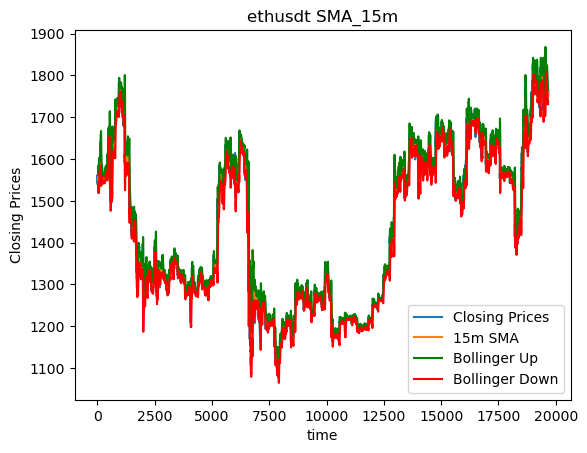

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()